Problem: Friedman-1 regression

__\<INCLUDE FORMULA\>__

Description: Page 207 DEAP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# used libraries
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


sys.path.append(os.path.join('..', '..'))
import pywinEA2

In [3]:
# genetic algorithm parameters
POPULATION_SIZE = 50
MAX_GENERATIONS = 50
N_RECURSIVE_ITERATIONS = 4
OPTIM_SCORE = 'mean_squared_error'
OPTIM = 'min'
PROB_MUTATION = 0.25
PROB_CROSSOVER = 0.75
SELECTION_OP = 'tournament'
MUTATION_OP = 'bit_flip'

# dataset creation parameters
N_SAMPLES = 200
N_FEATURES = 500
NOISE = 0.5

# misc
SEED = 1997


In [4]:
def getDataset() -> pd.DataFrame:
    """ Create the testing dataset """
    X, y = datasets.make_friedman1(
        n_samples=N_SAMPLES,
        n_features=N_FEATURES,
        noise=NOISE,
        random_state=SEED)
    
    X = pd.DataFrame(X, columns=['feat_{}'.format(f) for f in range(X.shape[1])])
    y = pd.DataFrame(y, columns=['target'])
    data = pd.concat([X, y], axis=1)
    
    return data

In [5]:
data = getDataset()
data.head(5)

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_491,feat_492,feat_493,feat_494,feat_495,feat_496,feat_497,feat_498,feat_499,target
0,0.771148,0.074757,0.526310,0.975088,0.992226,0.465135,0.611135,0.569463,0.667719,0.786780,...,0.802945,0.590838,0.997760,0.690453,0.625186,0.040616,0.574526,0.683321,0.153484,17.082650
1,0.316546,0.457287,0.721017,0.028663,0.623670,0.936549,0.306067,0.131824,0.609781,0.942532,...,0.550755,0.610305,0.391584,0.658611,0.931838,0.056777,0.056389,0.806717,0.348400,9.319051
2,0.973977,0.709694,0.964321,0.618567,0.114940,0.978974,0.456353,0.782813,0.876677,0.678804,...,0.942121,0.912058,0.464577,0.054383,0.792397,0.701524,0.514992,0.993746,0.033966,18.692444
3,0.401484,0.057108,0.925435,0.422867,0.496634,0.769792,0.978067,0.637003,0.091043,0.232143,...,0.090742,0.220962,0.193002,0.703279,0.100004,0.057513,0.394312,0.312684,0.753344,10.495461
4,0.264394,0.797688,0.669919,0.783029,0.347581,0.336558,0.058779,0.632744,0.720600,0.757688,...,0.012301,0.761392,0.118631,0.719180,0.966833,0.435286,0.154155,0.657826,0.465735,15.647972


In [6]:
# create the model
model = KNeighborsRegressor()

In [7]:
baseline_model = model.fit(data[data.columns.tolist()[:-1]], data['target'])
y_pred = baseline_model.predict(data[data.columns.tolist()[:-1]])
baseline_mse = np.mean((y_pred - data['target'].values)**2)
print('Baseline (all feats) MSE: {:.3f}'.format(baseline_mse))

baseline_model = model.fit(data[['feat_%d' % i for i in range(5)]], data['target'])
y_pred = baseline_model.predict(data[['feat_%d' % i for i in range(5)]])
baseline_mse = np.mean((y_pred - data['target'].values)**2)
print('Baseline (target feats) MSE: {:.3f}'.format(baseline_mse))

Baseline (all feats) MSE: 15.155
Baseline (target feats) MSE: 3.271


100%|███████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.86it/s]


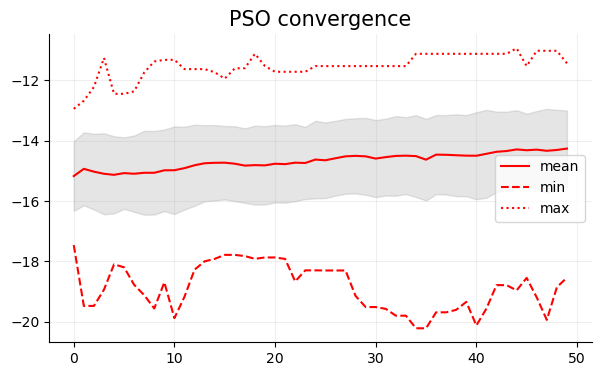

(200, 335)


100%|███████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.16it/s]


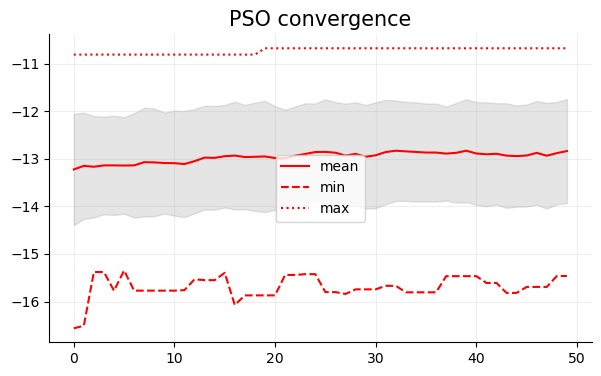

(200, 265)


100%|███████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.87it/s]


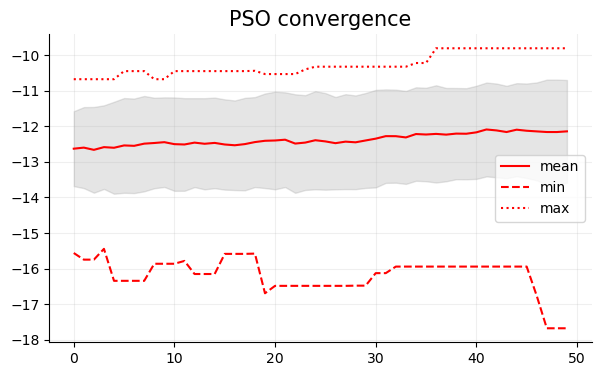

(200, 226)


100%|███████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.73it/s]


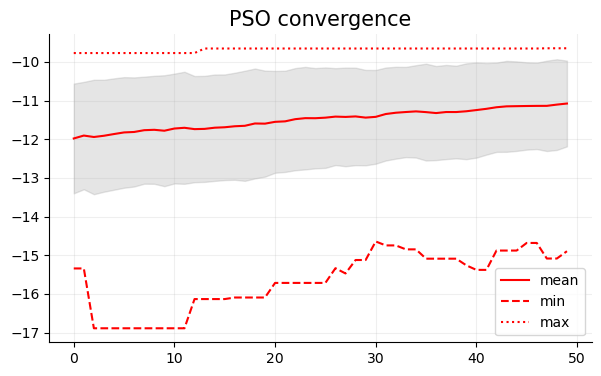

(200, 208)


In [11]:
curr_features = data.columns.tolist()[:-1]
curr_data = data.copy()
report_histories = []
for it in range(N_RECURSIVE_ITERATIONS):
    
    # create fitness function
    fitness_function = pywinEA2.fitness.FeatureSelectionFitness(
        model=model,
        score='mean_squared_error',
        X=data[curr_features].values,
        y=data['target'],
        X_fixed=None,
        cv=None,
        n_jobs=1
    )
    
    if it == 0:
        # create the genetic algorithm instance    
        report = pywinEA2.pso.psoSimple(
            population_size=POPULATION_SIZE,
            fitness_function=fitness_function,
            max_iterations=MAX_GENERATIONS,
            pso_evaluation='binary',
            pso_evaluation_kw=dict(
                invert_objective=True, 
                threshold=0.8,
                n_jobs=15
            ),
            pso_reference_update='simple',
            particle_update='simple_dynamic_inertia',
            particle_update_kw=dict(
                inertia=0.1,
                acc_const1=0.05,
                acc_const2=0.05,
                clip_values=(0, 1),
                dynamic_inertia_weight=0.5,

            ),
            particle_init_position='random',
            particle_init_speed='random',
            report=pywinEA2.pso.PSOReport(['min', 'max', 'mean', 'std']),
            verbose=True,
            seed=1997   
        )
    else:
        new_particles = pywinEA2.pso.population.removeParticleFeatures(
                report.particles, mask=feature_mask)
        # create the genetic algorithm instance    
        report = pywinEA2.pso.psoSimple(
            population=new_particles,
            fitness_function=fitness_function,
            max_iterations=MAX_GENERATIONS,
            pso_evaluation='binary',
            pso_evaluation_kw=dict(
                invert_objective=True, 
                threshold=0.8,
                n_jobs=1
            ),
            pso_reference_update='simple',
            particle_update='simple_dynamic_inertia',
            particle_update_kw=dict(
                inertia=0.1,
                acc_const1=0.05,
                acc_const2=0.05,
                clip_values=(0, 1),
                dynamic_inertia_weight=0.5,

            ),
            particle_init_position='random',
            particle_init_speed='random',
            report=pywinEA2.pso.PSOReport(['min', 'max', 'mean', 'std']),
            verbose=True,
            seed=1997   
        )
        
    report.displayConvergence()
    
    # save report history
    report_histories.append(pd.DataFrame(report.history).T)
    
    # update features
    feature_mask = report.particles[0].gbest > 0.8
    curr_features = np.array(curr_features)[feature_mask].tolist()
    curr_data = data[curr_features + ['target']].copy()
    
    print(curr_data.shape)
    
# concatenate all the reports
report_histories = pd.concat(report_histories, axis=0)
report_histories.index = np.arange(report_histories.shape[0])

In [9]:
assert False

AssertionError: 

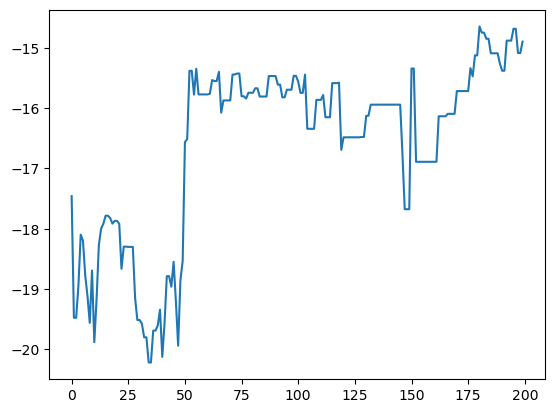

In [12]:
plt.plot(report_histories['min'])

In [ ]:
assert False

In [ ]:
curr_features = data.columns.tolist()[:-1]
curr_data = data.copy()
report_histories = []
for it in range(N_RECURSIVE_ITERATIONS):
    # create the genetic algorithm instance
    obj = pywinEA2.MultiObjFeatureSelectionNSGA2(
        data=data,
        model=model,
        score=OPTIM_SCORE,
        y=['target'],
        population_size=int(POPULATION_SIZE * 2**it), 
        p_crossover=PROB_CROSSOVER,
        p_mutation=PROB_MUTATION,
        max_generations=MAX_GENERATIONS * 2**it,
        target_feats=curr_features,
        optim=OPTIM,
        selection_op=SELECTION_OP,
        mutation_op=MUTATION_OP)
    
    print('POPULATION SIZE: %d' % int(POPULATION_SIZE * 2**it))
    print('POPULATION SIZE: %d' % int(MAX_GENERATIONS * 2**it))
    
    report = pywinEA2.run(obj, type='nsga2', verbose=True)
    
    # get report history
    history = pd.DataFrame({k: report.get(k) for k in report.keys})
    for stat in ['min', 'max', 'mean']:
        multiobj_stat = np.stack(report.get('multiobj_fitness_values_%s' % stat))
        history['multiobj_%s0' % stat] = multiobj_stat[:, 0]
        history['multiobj_%s1' % stat] = multiobj_stat[:, 1]
    report_histories.append(history)
    
    # sum all the features from the population
    feature_sel_mask = (np.array(list(report.population)).sum(axis=0) > 0)
    curr_features = curr_data.drop(columns=['target']).columns[feature_sel_mask].values.tolist()
    curr_data = data[curr_features + ['target']].copy()
    
    for c in ['feat_%d' % i for i in range(5)]:
        if c not in curr_data.columns:
            assert False, 'Missing %s' % c
    
# concatenate all the reports
report_histories = pd.concat(report_histories, axis=0)
report_histories.index = np.arange(report_histories.shape[0])

In [ ]:
obj.getFitnessObj()

In [ ]:
perfect_ind = np.zeros(len(report.pareto_front[0])).astype(int).tolist()
perfect_ind[:5] = [1, 1, 1, 1, 1]
obj.getFitnessObj()(perfect_ind)

In [ ]:
for ind in report.pareto_front:
    print(ind[:10])
    print(obj.getFitnessObj()(ind))

In [ ]:
for ind in report.population:
    print(ind[:10])
    print(obj.getFitnessObj()(ind))

In [ ]:
len(report.population)

In [ ]:
assert False

In [ ]:
assert False

In [ ]:
plt.plot(pd.concat(report_histories, axis=0)['multiobj_min0'].values)

In [ ]:
np.array(list(report.pareto_front))

In [ ]:
plt.plot(report_histories['multiobj_min0'])

In [ ]:
report_histories

In [ ]:
history

In [ ]:
report.logbook

In [ ]:
report.get(['multiobj_fitness_values_min', 'multiobj_fitness_values_min', 'multiobj_fitness_values_min'])

In [ ]:
report.logbook

In [ ]:
assert False

In [ ]:
curr_data[best_features + ['target']]

In [ ]:
    ind_features = curr_data.columns[np.array(ind) == 1].values
    fitted_model = model.fit(curr_data[ind_features].values, y_train.values)
    y_pred = fitted_model.predict(X_test_unisel[ind_features].values)
    score = obj._fitness_obj._score(y_pred=y_pred, y_true=y_test.values)

    pareto_front_scores.append(score)
    pareto_front_features.append(ind_features)

In [ ]:
report = pywinEA2.run(obj, type='nsga2', verbose=True)

In [ ]:
report.displayConvergence(title='Convergence')

In [ ]:
report.displayMultiObjectiveConvergence(title='Convergence', objective_names=['MSE', 'Features'])

In [ ]:
report.displayParetoFront(objective_names=['MSE', 'Features'])

In [ ]:
data.columns.values[:-1][np.array(report.hall_of_fame[0], dtype=bool)]  # optimal solution

In [ ]:
pywinEA2.save(report, 'test', extension='report')

In [ ]:
pywinEA2.load('test.report')